This is an exercise given in the [codebasics video](https://www.youtube.com/watch?v=ZN6P_GEJ7lk) . The code is also taken from the same video. 

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [21]:
# inital variables
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS= 3
EPOCHS= 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

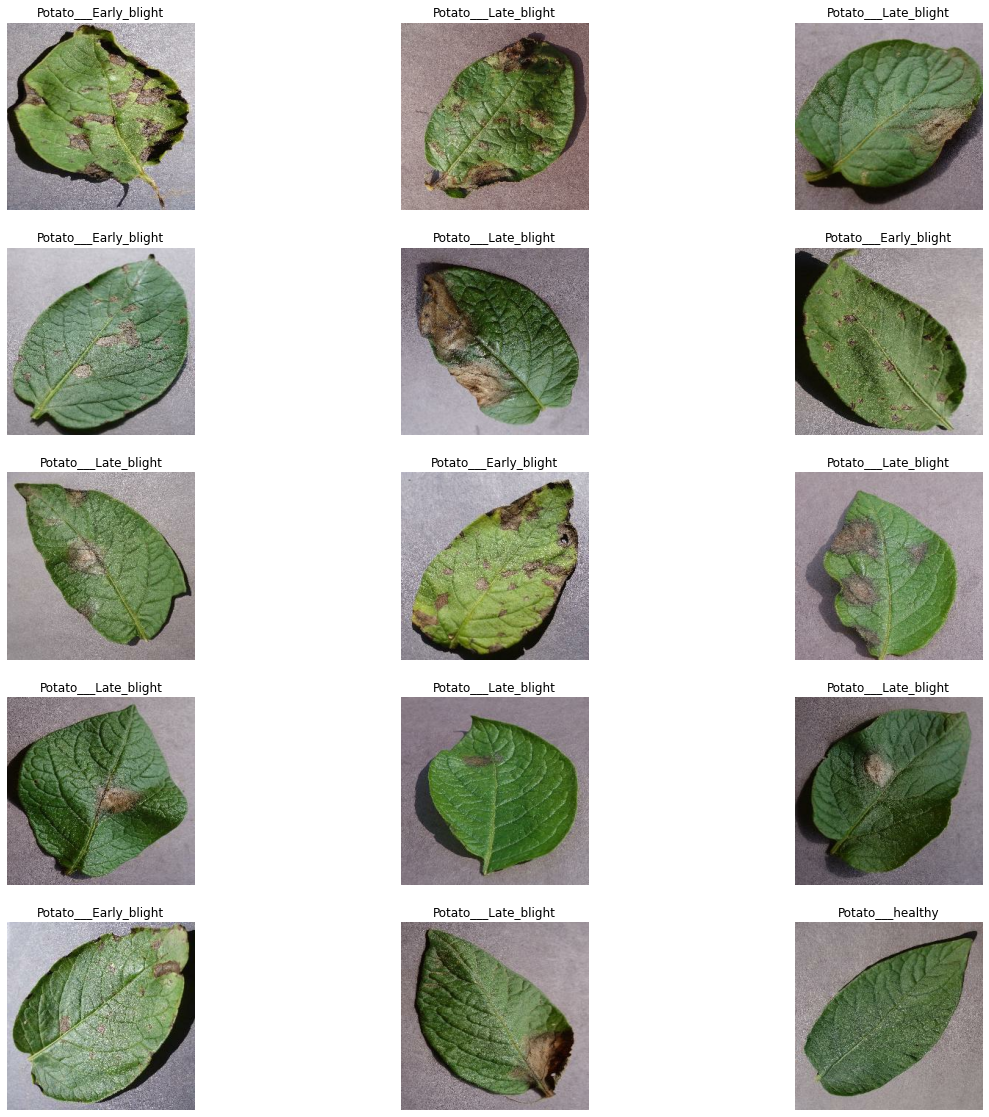

In [6]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Model Trianing

## Train, Validation, Test Split

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(dataset)

135

In [10]:
print(len(train_ds), len(val_ds),len(test_ds)) 

108 13 14


## Cache, Shuffle, and Prefetch the Dataset


In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.5),
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3))
])

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (16, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (16, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (16, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (16, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (16, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (16, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (16, 30, 30, 64)         

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    #callbacks=[EarlyStopping(monitor='val_loss', patience=10)]
)

Epoch 1/50
108/108 [==============================] - 181s 2s/step - loss: 0.9272 - accuracy: 0.4780 - val_loss: 0.8874 - val_accuracy: 0.4800
Epoch 2/50
108/108 [==============================] - 104s 961ms/step - loss: 0.8272 - accuracy: 0.5938 - val_loss: 0.6634 - val_accuracy: 0.7050
Epoch 3/50
108/108 [==============================] - 106s 979ms/step - loss: 0.6042 - accuracy: 0.7645 - val_loss: 0.8669 - val_accuracy: 0.6400
Epoch 4/50
108/108 [==============================] - 113s 1s/step - loss: 0.4303 - accuracy: 0.8380 - val_loss: 0.5529 - val_accuracy: 0.7900
Epoch 5/50
108/108 [==============================] - 114s 1s/step - loss: 0.3584 - accuracy: 0.8628 - val_loss: 0.4474 - val_accuracy: 0.7950
Epoch 6/50
108/108 [==============================] - 114s 1s/step - loss: 0.3020 - accuracy: 0.8814 - val_loss: 0.3492 - val_accuracy: 0.8250
Epoch 7/50
108/108 [==============================] - 114s 1s/step - loss: 0.2598 - accuracy: 0.9039 - val_loss: 0.2718 - val_accuracy: 

In [19]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 3s 202ms/step - loss: 0.2238 - accuracy: 0.9241


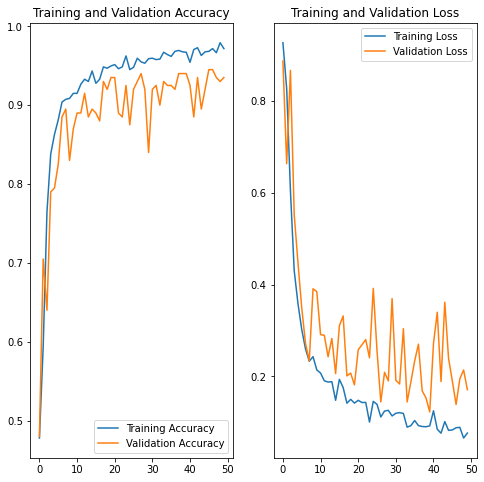

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___healthy


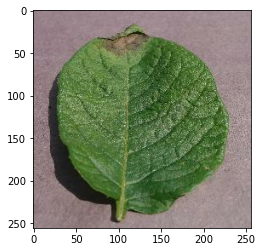

In [55]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [62]:
y_predicted = model.predict(test_ds)
y_predicted_labels = [np.argmax(i) for i in y_predicted]

In [63]:
y_test = []

for images_batch, labels_batch in test_ds:
    for i in labels_batch.numpy():
        y_test.append(i)

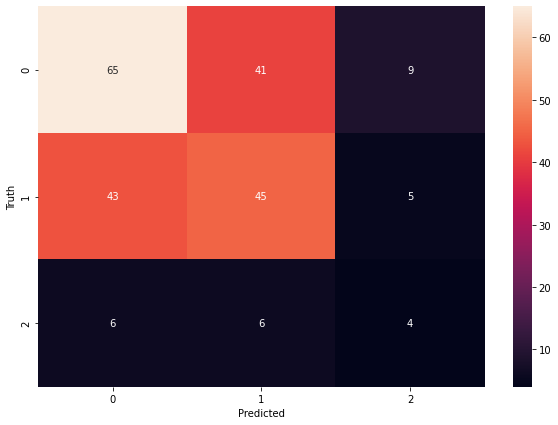

In [65]:
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_labels)

import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()